# 第14章 TensorFlowのメカニズム

より高度なディープラーニングモデルを実装するための準備を整えよう

## 14.1 TensorFlowの主な特徴

## 14.2 TensorFlowの計算フラグ：TensorFlow 2.x への移行

- 単純な算術演算のグラフをどのように定義するか
- グラフをTensorFlow 2.x に移行する方法
- **Eager Execution**（つまり動的グラフ）のパラダイム
- 計算を高速化する関数デコレーション

### 14.2.1 計算グラフ

$z=2\times(a-b)+c$を評価したいとする

### 14.2.2 TensorFlow 1.x で計算グラフを作成する

In [1]:
import tensorflow as tf

2024-12-24 10:57:35.605065: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
## TensorFlow 1.x のスタイル
g = tf.Graph()
## 計算グラフにノードを追加
with g.as_default():
    a = tf.constant(1, name="a")
    b = tf.constant(2, name="b")
    c = tf.constant(3, name="c")
    z = 2*(a-b) + c

In [3]:
## TensorFlow 1.x のスタイル
with tf.compat.v1.Session(graph=g) as sess:
    print("Result: z=", sess.run(z))

Result: z= 1


2024-12-16 12:05:13.682273: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:388] MLIR V1 optimization pass is not enabled


### 14.2.3 計算グラフをTensorFlow 2.x に移行させる

In [4]:
## TensorFlow 2.x のスタイル
a = tf.constant(1, name="a")
b = tf.constant(2, name="b")
c = tf.constant(3, name="c")
z = 2*(a-b) + c
tf.print("Result: z = ", z)

Result: z =  1


### 14.2.4 TensorFlow 1.xでデータをモデルに読み込む

In [5]:
## TensorFlow 1.x のスタイル
g = tf.Graph()
with g.as_default():
    a = tf.compat.v1.placeholder(shape=None, dtype=tf.int32, name="tf_a")
    b = tf.compat.v1.placeholder(shape=None, dtype=tf.int32, name="tf_b")
    c = tf.compat.v1.placeholder(shape=None, dtype=tf.int32, name="tf_c")
    z = 2*(a-b) + c

with tf.compat.v1.Session(graph=g) as sess:
    feed_dict = {a:1, b:2, c:3}
    print("Result: z =", sess.run(z, feed_dict=feed_dict))

Result: z = 1


### 14.2.5 TensorFlow 2.x でデータをモデルに読み込む

In [6]:
## TensorFlow 2.xのスタイル
def compute_z(a, b, c):
    r1 = tf.subtract(a, b)
    r2 = tf.multiply(2, r1)
    z = tf.add(r2, c)
    return z

In [7]:
tf.print("Scaler Inputs:", compute_z(1, 2, 3))
tf.print("Rank 1 Inputs:", compute_z([1], [2], [3]))
tf.print("Rank 2 Inputs:", compute_z([[1]], [[2]], [[3]]))

Scaler Inputs: 1
Rank 1 Inputs: [1]
Rank 2 Inputs: [[1]]


### 14.2.6 関数デコレータによる計算性能の改善

In [8]:
@tf.function
def compute_z(a, b, c):
    r1 = tf.subtract(a, b)
    r2 = tf.multiply(2, r1)
    z = tf.add(r2, c)
    return z

In [9]:
tf.print("Scaler Inputs:", compute_z(1, 2, 3))
tf.print("Rank 1 Inputs:", compute_z([1], [2], [3]))
tf.print("Rank 2 Inputs:", compute_z([[1]], [[2]], [[3]]))

Scaler Inputs: 1
Rank 1 Inputs: [1]
Rank 2 Inputs: [[1]]


In [10]:
@tf.function(input_signature=(tf.TensorSpec(shape=[None], dtype=tf.int32),
                             tf.TensorSpec(shape=[None], dtype=tf.int32),
                             tf.TensorSpec(shape=[None], dtype=tf.int32),))
def compute_z(a, b, c):
    r1 = tf.subtract(a, b)
    r2 = tf.multiply(2, r1)
    z = tf.add(r2, c)
    return z

In [11]:
tf.print("Rank 1 Inputs:", compute_z([1], [2], [3]))
tf.print("Rank 1 Inputs:", compute_z([1, 2], [2, 4], [3, 6]))

Rank 1 Inputs: [1]
Rank 1 Inputs: [1 2]


## 14.3 TensorFlowのVariableオブジェクト：モデルパラメータの格納と更新

TensorFlowの`Variable`は、訓練中にモデルのパラメータを格納・更新できるようにする特別な`Tensor`オブジェクトである。

`Variable`を作成するには、ユーザー指定の入力値で`tf.Variable()`を呼び出せばよい。

In [3]:
a = tf.Variable(initial_value=3.14, name="var_a")
print(a)

<tf.Variable 'var_a:0' shape=() dtype=float32, numpy=3.14>


In [4]:
b = tf.Variable(initial_value=[1, 2, 3], name="var_b")
print(b)

<tf.Variable 'var_b:0' shape=(3,) dtype=int32, numpy=array([1, 2, 3], dtype=int32)>


In [6]:
c = tf.Variable(initial_value=[True, False], dtype=tf.bool)
print(c)

<tf.Variable 'Variable:0' shape=(2,) dtype=bool, numpy=array([ True, False])>


In [7]:
d = tf.Variable(initial_value=["abc"], dtype=tf.string)
print(d)

<tf.Variable 'Variable:0' shape=(1,) dtype=string, numpy=array([b'abc'], dtype=object)>


`Variable`を作成するときは、常に初期値を指定しなければならないことに注意

訓練可能ではない変数は次のように定義できる。

In [8]:
w = tf.Variable([1, 2, 3], trainable=False)
print(w.trainable)

False


`Variable`の値は`assign`や`assign_add`などのメゾットを実行することで効率よく変更できる。

In [9]:
print(w.assign([3, 1, 4], read_value=True))

<tf.Variable 'UnreadVariable' shape=(3,) dtype=int32, numpy=array([3, 1, 4], dtype=int32)>


In [10]:
w.assign_add([2, -1, 2], read_value=False)
print(w.value())

tf.Tensor([5 0 6], shape=(3,), dtype=int32)


TensorFlowの`Variable`を作成するときも、乱数の初期化を利用することができる。

TensorFlowの`tf.random`モジュールを使ってさまざまな分布の乱数を生成できる。

Glorot初期化を使って`Variable`を作成できることを確認する。

In [2]:
tf.random.set_seed(1)
init = tf.keras.initializers.GlorotNormal()
tf.print(init(shape=(3,)))

[0.458178699 -0.602661967 0.497707337]


この演算子を使って2×3の形状を持つ`Variable`を初期化できる

In [3]:
v = tf.Variable(init(shape=(2, 3)))
tf.print(v)

[[0.501909614 -0.660183072 0.545211077]
 [-0.548415601 0.474084854 0.80210489]]


`tf.Module`クラスの中で`Variable`を定義する方法を見てみよう。

In [4]:
class MyModel(tf.Module):
    def __init__(self):
        init = tf.keras.initializers.GlorotNormal()
        self.w1 = tf.Variable(init(shape=(2, 3)), trainable=True)
        self.w2 = tf.Variable(init(shape=(1, 2)), trainable=False)

m = MyModel()
print("All module variables:", [v.shape for v in m.variables])

All module variables: [TensorShape([2, 3]), TensorShape([1, 2])]


In [5]:
print("Trainable variables:", [v.shape for v in m.trainable_variables])

Trainable variables: [TensorShape([2, 3])]


最後に、`tf.function`でデコレートされた関数の外で変数を定義する必要がある

In [3]:
tf.random.set_seed(1)
w = tf.Variable(tf.random.uniform((3, 3)))
@tf.function
def compute_z(x):
    return tf.matmul(w, x)

In [4]:
x = tf.constant([[1], [2], [3]], dtype=tf.float32)
tf.print(compute_z(x))

[[3.8610158]
 [2.94593048]
 [3.82629013]]


## 14.4 自動微分とGradientTapeによる勾配の計算

何らかの変数を使った演算の勾配を計算する方法について説明する

### 14.4.1 訓練可能な変数について損失項の勾配を計算する

TensorFlowは**自動微分**をサポートしている。

**自動微分**については、入れ子の関数の勾配を計算するための**連鎖律**の実装として考えられる。

In [13]:
w = tf.Variable(1.0)
b = tf.Variable(0.5)
print(w.trainable, b.trainable)

True True


In [14]:
x = tf.convert_to_tensor([1.4])
y = tf.convert_to_tensor([2.1])
with tf.GradientTape() as tape:
    z = tf.add(tf.multiply(w, x), b)
    loss = tf.reduce_sum(tf.square(y - z))
dloss_dw = tape.gradient(loss, w)
tf.print("dL/dw:", dloss_dw)

dL/dw: -0.559999764


In [15]:
## 計算した勾配を検証
tf.print(2*x*(w*x+b-y))

[-0.559999764]


### 14.4.2 訓練可能ではない変数について勾配を計算する

In [16]:
with tf.GradientTape() as tape:
    tape.watch(x)
    z = tf.add(tf.multiply(w, x), b)
    loss = tf.reduce_sum(tf.square(y - z))

dloss_dx = tape.gradient(loss, x)
tf.print("dL/dx:", dloss_dx)

dL/dx: [-0.399999857]


### 14.4.3 複数の勾配計算のリソースを保持する

`tf.GradientTape`のコンテキストで計算を監視する際、勾配テープはデフォルトで1つの勾配計算のリソースしか保持されない。

複数の勾配を計算したい場合は、勾配テープの永続化が必要となる。

In [17]:
with tf.GradientTape(persistent=True) as tape:
    z = tf.add(tf.multiply(w, x), b)
    loss = tf.reduce_sum(tf.square(y - z))

In [18]:
dloss_dw = tape.gradient(loss, w)
tf.print("dL/dw:", dloss_dw)

dL/dw: -0.559999764


In [19]:
dloss_db = tape.gradient(loss, b)
tf.print("dL/db:", dloss_db)

dL/db: -0.399999857


`tf.keras`を使ってパラメータを最適化できることを示す

In [20]:
optimizer = tf.keras.optimizers.SGD()
optimizer.apply_gradients(zip([dloss_db, dloss_db], [w, b]))
tf.print("Updated w:", w)
tf.print("Updated bias:", b)

Updated w: 1.004
Updated bias: 0.504


## 14.5 Keras APIを使って一般的なアーキテクチャの実装を単純化する

In [2]:
model = tf.keras.Sequential()
model.add(tf.keras.layers.Dense(units=16, activation="relu"))
model.add(tf.keras.layers.Dense(units=32, activation="relu"))
## 遅延変数作成
model.build(input_shape=(None, 4))
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 16)             │            80 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │           544 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 624 (2.44 KB)

 Trainable params: 624 (2.44 KB)

 Non-trainable params: 0 (0.00 B)

1つ目の層は$16 \times 4 + 16 = 80$、2つ目の層は$16 \times 32 + 32 = 544$である。

変数（モデルパラメータ）が作成されたら、訓練可能な変数と訓練可能ではない変数に次のようにアクセスできる

In [3]:
## モデルの変数を出力
for v in model.variables:
    print("{:20s}".format(v.name), v.trainable, v.shape)

kernel               True (4, 16)
bias                 True (16,)
kernel               True (16, 32)
bias                 True (32,)


In [4]:
model = tf.keras.Sequential()
model.add(tf.keras.layers.Dense(
    units=16,
    activation=tf.keras.activations.relu,
    kernel_initializer=tf.keras.initializers.glorot_uniform(),
    bias_initializer=tf.keras.initializers.Constant(2.0),
))
model.add(tf.keras.layers.Dense(
    units=32,
    activation=tf.keras.activations.sigmoid,
    kernel_regularizer=tf.keras.regularizers.l1,
))

In [5]:
model.compile(
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.001),
    loss=tf.keras.losses.BinaryCrossentropy(),
    metrics=[
        tf.keras.metrics.Accuracy(),
        tf.keras.metrics.Precision(),
        tf.keras.metrics.Recall(),
    ],
)

### 14.5.1 XOR分類問題を解く

実践的な例として、Keras APIを使ってXOR分類問題を解いてみよう。

`tf.keras.Sequential`クラスを使ってモデルを構築する。<br>
その過程で非線形の決定境界に対処するモデルのキャパシティも確認する。

XOR分類問題は、「2つのクラス間での非線形の決定境界の捕捉」に関してモデルのキャパシティを分類するという古典的な問題である。

データを生成して訓練データセットと検証データセットに分割するコードは次のようになる。

In [2]:
import tensorflow as tf

2024-12-29 00:37:13.891407: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [141]:
%pip install mlxtend

  Using cached mlxtend-0.23.3-py3-none-any.whl.metadata (7.3 kB)
Using cached mlxtend-0.23.3-py3-none-any.whl (1.4 MB)
Note: you may need to restart the kernel to use updated packages.


In [142]:
from mlxtend.plotting import plot_decision_regions

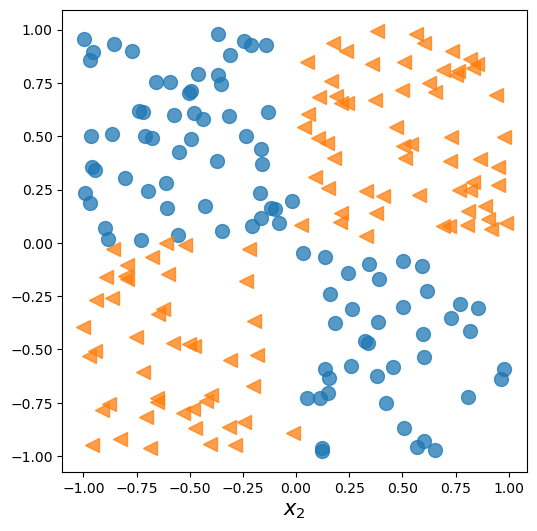

In [5]:
import numpy as np
import matplotlib.pyplot as plt
tf.random.set_seed(1)
np.random.seed(1)
x = np.random.uniform(low=-1, high=1, size=(200, 2))
y = np.ones(len(x))
y[x[:, 0] * x[:, 1] < 0] = 0
x_train = x[:100, :]
y_train = y[:100]
x_valid = x[100:, :]
y_valid = y[100:]
fig = plt.figure(figsize=(6, 6))
plt.plot(x[y==0, 0], x[y==0, 1], "o", alpha=0.75, markersize=10)
plt.plot(x[y==1, 0], x[y==1, 1], "<", alpha=0.75, markersize=10)
plt.xlabel(r"$x_1$", size=15)
plt.xlabel(r"$x_2$", size=15)
plt.show()

パラメータの数が多いほどネットワークがより複雑な関数に適合できることを意味するが、通常はモデルが大きくなるほど訓練が難しくなる。

実際には、ロジスティック回帰といった単層ニューラルネットワークなど、ベースラインとして単純なモデルから始めるのが常によい考えである。

In [3]:
model = tf.keras.Sequential()
model.add(tf.keras.layers.Dense(units=1, input_shape=(2,), activation="sigmoid"))
model.summary()

/opt/conda/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 1)              │             3 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3 (12.00 B)

 Trainable params: 3 (12.00 B)

 Non-trainable params: 0 (0.00 B)

In [5]:
model.compile(optimizer=tf.keras.optimizers.SGD(),
             loss=tf.keras.losses.BinaryCrossentropy(),
             metrics=[tf.keras.metrics.BinaryAccuracy()])
hist = model.fit(x_train, y_train,
                validation_data=(x_valid, y_valid),
                epochs=200, batch_size=2, verbose=0)

/tmp/ipykernel_111/2071287988.py:15: DeprecationWarning: Converting `np.integer` or `np.signedinteger` to a dtype is deprecated. The current result is `np.dtype(np.int_)` which is not strictly correct. Note that the result depends on the system. To ensure stable results use may want to use `np.int64` or `np.int32`.
  plot_decision_regions(X=x_valid, y=y_valid.astype(np.integer), clf=model)


20000/20000 ━━━━━━━━━━━━━━━━━━━━ 23s 1ms/step


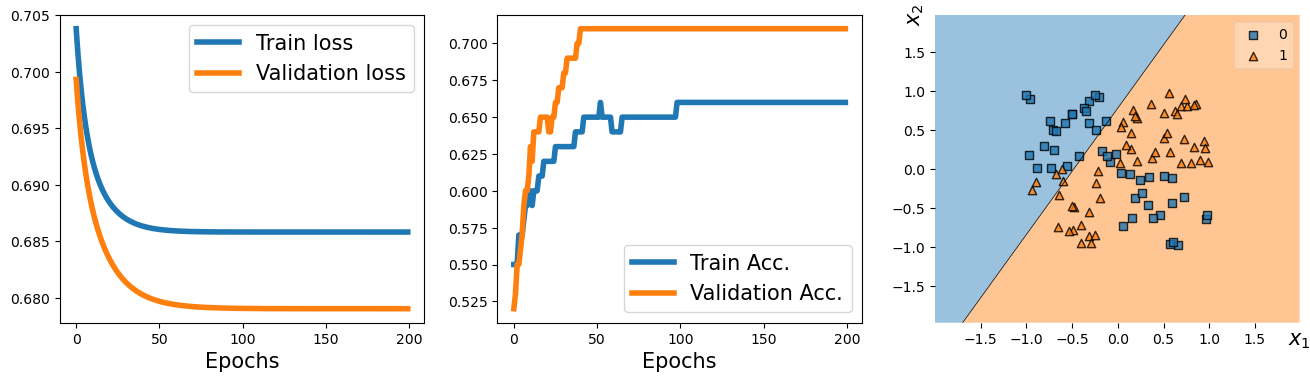

In [7]:
history = hist.history
fig = plt.figure(figsize=(16, 4))
ax = fig.add_subplot(1, 3, 1)
plt.plot(history["loss"], lw=4)
plt.plot(history["val_loss"], lw=4)
plt.legend(["Train loss", "Validation loss"], fontsize=15)
ax.set_xlabel("Epochs", size=15)
ax = fig.add_subplot(1, 3, 2)
plt.plot(history["binary_accuracy"], lw=4)
plt.plot(history["val_binary_accuracy"], lw=4)
plt.legend(["Train Acc.", "Validation Acc."], fontsize=15)
ax.set_xlabel("Epochs", size=15)
ax = fig.add_subplot(1, 3, 3)
plot_decision_regions(X=x_valid, y=y_valid.astype(np.integer), clf=model)
ax.set_xlabel(r"$x_1$", size=15)
ax.xaxis.set_label_coords(1, -0.025)
ax.set_ylabel(r"$x_2$", size=15)
ax.yaxis.set_label_coords(-0.025, 1)
plt.show()

損失率、正解率、そして決定境界に沿った検証データの散布図が3つのパネルに分かれている。

隠れ層を持たない単純なモデルは線形の決定境界しか抽出できないため、XOR問題を解くのは不可能である。

結果として、訓練データセットと検証データセットの両方で損失項の値が非常に大きいことと、分解正解率が非常に低いことが確認できる。

XOR問題により的確に取り組む方法の1つは、隠れ層を追加して、検証データセットで満足のいく結果が観測されるまで隠れユニットの個数を変えながら比較することである。

あるいは、隠れ層をさらに追加して、さらに深いモデルにすることもできる。

ネットワークを深くすると、同等の性能を達成するのに必要なパラメータの個数が少なくなるという利点がある。

ただし、深いモデルには、勾配消失問題や勾配発散問題に陥りやすく、訓練するのが難しくなるという問題がある。

練習がてら、4つの隠れユニットを持つ隠れ層を1～4個追加してみよう。

次の例は、3つの隠れ層を持つフィードフォワードニューラルネットワークの結果を示している。

In [8]:
tf.random.set_seed(1)
model = tf.keras.Sequential()
model.add(tf.keras.Input(shape=(2,)))
model.add(tf.keras.layers.Dense(units=4, activation="relu"))
model.add(tf.keras.layers.Dense(units=4, activation="relu"))
model.add(tf.keras.layers.Dense(units=4, activation="relu"))
model.add(tf.keras.layers.Dense(units=1, activation="sigmoid"))
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_4 (Dense)                 │ (None, 4)              │            12 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 4)              │            20 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 4)              │            20 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │             5 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 57 (228.00 B)

 Trainable params: 57 (228.00 B)

 Non-trainable params: 0 (0.00 B)

In [12]:
model.compile(optimizer=tf.keras.optimizers.SGD(),
             loss=tf.keras.losses.BinaryCrossentropy(),
             metrics=[tf.keras.metrics.BinaryAccuracy()])
hist = model.fit(x_train, y_train, validation_data=(x_valid, y_valid),
                epochs=200, batch_size=2, verbose=0)

/tmp/ipykernel_112/560639765.py:14: DeprecationWarning: Converting `np.integer` or `np.signedinteger` to a dtype is deprecated. The current result is `np.dtype(np.int_)` which is not strictly correct. Note that the result depends on the system. To ensure stable results use may want to use `np.int64` or `np.int32`.
  plot_decision_regions(X=x_valid, y=y_valid.astype(np.integer), clf=model)


20000/20000 ━━━━━━━━━━━━━━━━━━━━ 22s 1ms/step


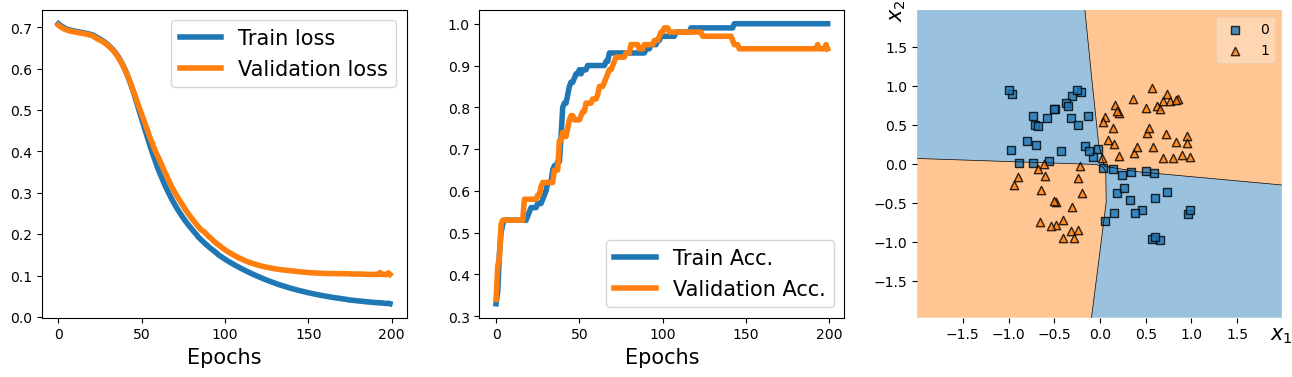

In [13]:
history = hist.history
fig = plt.figure(figsize=(16, 4))
ax = fig.add_subplot(1, 3, 1)
plt.plot(history["loss"], lw=4)
plt.plot(history["val_loss"], lw=4)
plt.legend(["Train loss", "Validation loss"], fontsize=15)
ax.set_xlabel("Epochs", size=15)
ax = fig.add_subplot(1, 3, 2)
plt.plot(history["binary_accuracy"], lw=4)
plt.plot(history["val_binary_accuracy"], lw=4)
plt.legend(["Train Acc.", "Validation Acc."], fontsize=15)
ax.set_xlabel("Epochs", size=15)
ax = fig.add_subplot(1, 3, 3)
plot_decision_regions(X=x_valid, y=y_valid.astype(np.integer), clf=model)
ax.set_xlabel(r"$x_1$", size=15)
ax.xaxis.set_label_coords(1, -0.025)
ax.set_ylabel(r"$x_2$", size=15)
ax.yaxis.set_label_coords(-0.025, 1)
plt.show()

このように、モデルがこのデータから非線形の決定境界を抽出できるようになった。

訓練データセットでの正解率は100%に達している。検証データセットでの正解率は95%であり、このモデルはわずかながら過学習していることを示している。

### 14.5.2 KerasのFunctional API を使ってより柔軟にモデルを構築する

In [14]:
tf.random.set_seed(1)
## 入力層
inputs = tf.keras.Input(shape=(2,))
## 隠れ層
h1 = tf.keras.layers.Dense(units=4, activation="relu")(inputs)
h2 = tf.keras.layers.Dense(units=4, activation="relu")(h1)
h3 = tf.keras.layers.Dense(units=4, activation="relu")(h2)
## 出力層
outputs = tf.keras.layers.Dense(units=1, activation="sigmoid")(h3)
## モデルを構築
model = tf.keras.Model(inputs=inputs, outputs=outputs)
model.summary()

Model: "functional_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 4)              │            12 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 4)              │            20 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 4)              │            20 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 1)              │             5 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 57 (228.00 B)

 Trainable params: 57 (228.00 B)

 Non-trainable params: 0 (0.00 B)

In [15]:
model.compile(optimizer=tf.keras.optimizers.SGD(),
             loss=tf.keras.losses.BinaryCrossentropy(),
             metrics=[tf.keras.metrics.BinaryAccuracy()])
hist = model.fit(x_train, y_train, validation_data=(x_valid, y_valid),
                epochs=200, batch_size=2, verbose=0)

### 14.5.3 KerasのModelクラスに基づいてモデルを実装する

複雑なモデルを構築するもう1つの方法は、`tf.keras.Model`のサブクラス化である。

前項と同じモデルを実装する新しいクラスは次のように定義する。

In [3]:
class MyModel(tf.keras.Model):
    def __init__(self):
        super(MyModel, self).__init__()
        self.hidden_1 = tf.keras.layers.Dense(units=4, activation="relu")
        self.hidden_2 = tf.keras.layers.Dense(units=4, activation="relu")
        self.hidden_3 = tf.keras.layers.Dense(units=4, activation="relu")
        self.output_layer = tf.keras.layers.Dense(units=1, activation="sigmoid")

    def call(self, inputs):
        h = self.hidden_1(inputs)
        h = self.hidden_2(h)
        h = self.hidden_3(h)
        return self.output_layer(h)

`tf.keras.Model`のサブクラスであるモデルは、`build`、`compile`、`fit`など、モデルの一般的なメゾットを継承する。

このため、新しいクラスのインスタンスを作成した後は、`Keras`を使って構築した他のモデルと同じようにコンパイル/訓練できる。

In [6]:
tf.random.set_seed(1)
model = MyModel()
model.build(input_shape=(None, 2))
model.summary()
## コンパイル
model.compile(optimizer=tf.keras.optimizers.SGD(),
             loss=tf.keras.losses.BinaryCrossentropy(),
             metrics=[tf.keras.metrics.BinaryAccuracy()])
## 訓練
hist = model.fit(x_train, y_train,
                validation_data=(x_valid, y_valid),
                epochs=200, batch_size=2, verbose=0)

/opt/conda/lib/python3.11/site-packages/keras/src/layers/layer.py:391: UserWarning: `build()` was called on layer 'my_model_1', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


Model: "my_model_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_4 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

### 14.5.4 Keras を使ってカスタム層を記述する

Kerasがまだサポートしていない新しい層を定義したい場合は、`tf.keras.layers.Layer`クラスを継承する新しいクラスを定義できる。

この方法は、新しい層を設計したり、既存の層をカスタマイズしたりする場合に特に便利である。

単純な例として、$w(x+\epsilon) + b$を計算する新しい線形層を定義したいとしよう。$\epsilon$はランダムな変数を表す。

In [10]:
class NoisyLinear(tf.keras.layers.Layer):
    def __init__(self, output_dim, noise_stddev=0.1, **kwargs):
        self.output_dim = output_dim
        self.noise_stddev = noise_stddev
        super(NoisyLinear, self).__init__(**kwargs)

    def build(self, input_shape):
        self.w = self.add_weight(name="weights",
                                shape=(input_shape[1], self.output_dim),
                                initializer="random_normal",
                                trainable=True)
        self.b = self.add_weight(shape=(self.output_dim,),
                                initializer="zeros",
                                trainable=True)

    def call(self, inputs, training=False):
        if training:
            batch = tf.shape(inputs)[0]
            dim = tf.shape(inputs)[1]
            noise = tf.random.normal(shape=(batch, dim), mean=0.0,
                                    stddev=self.noise_stddev)
            noisy_inputs = tf.add(inputs, noise)
        else:
            noisy_inputs = inputs
        z = tf.matmul(noisy_inputs, self.w) + self.b
        return tf.keras.activations.relu(z)

    def get_config(self):
        config = super(NoisyLinear, self).get_config()
        config.update({"output_dim": self.output_dim,
                      "noise_stddev": self.noise_stddev})
        return config

In [14]:
tf.random.set_seed(1)
noisy_layer = NoisyLinear(4)
noisy_layer.build(input_shape=(None, 4))
x = tf.zeros(shape=(1, 4))
tf.print(noisy_layer(x, training=True))

[[0.00533614215 0 0 0]]


In [16]:
## configからの再構築
config = noisy_layer.get_config()
new_layer = NoisyLinear.from_config(config)
tf.print(new_layer(x, training=True))

[[0.00422844663 0.00148792611 0 0.00809221342]]


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ noisy_linear_6 (NoisyLinear)    │ (None, 4)              │            12 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 4)              │            20 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 4)              │            20 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 1)              │             5 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 57 (228.00 B)

 Trainable params: 57 (228.00 B)

 Non-trainable params: 0 (0.00 B)

/tmp/ipykernel_114/1732411167.py:34: DeprecationWarning: Converting `np.integer` or `np.signedinteger` to a dtype is deprecated. The current result is `np.dtype(np.int_)` which is not strictly correct. Note that the result depends on the system. To ensure stable results use may want to use `np.int64` or `np.int32`.
  plot_decision_regions(X=x_valid, y=y_valid.astype(np.integer), clf=model)


20000/20000 ━━━━━━━━━━━━━━━━━━━━ 21s 1ms/step


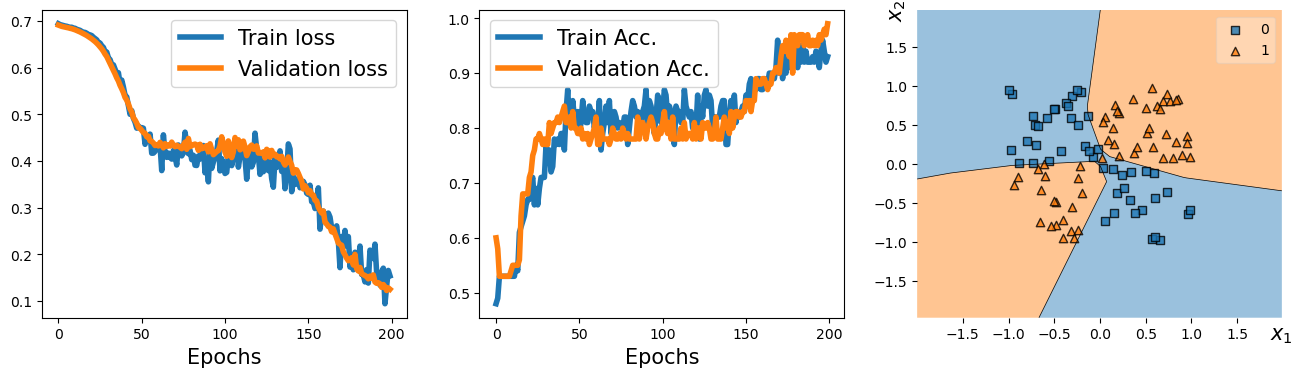

In [19]:
tf.random.set_seed(1)
model = tf.keras.Sequential([NoisyLinear(4, noise_stddev=0.1),
                             tf.keras.layers.Dense(units=4, activation="relu"),
                             tf.keras.layers.Dense(units=4, activation="relu"),
                             tf.keras.layers.Dense(units=1, activation="sigmoid")
                            ])
model.build(input_shape=(None, 2))
model.summary()

## コンパイル
model.compile(optimizer=tf.keras.optimizers.SGD(),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=[tf.keras.metrics.BinaryAccuracy()])

## 訓練
hist = model.fit(x_train, y_train,
                validation_data=(x_valid, y_valid),
                epochs=200, batch_size=2, verbose=0)

## プロット
history = hist.history
fig = plt.figure(figsize=(16, 4))
ax = fig.add_subplot(1, 3, 1)
plt.plot(history["loss"], lw=4)
plt.plot(history["val_loss"], lw=4)
plt.legend(["Train loss", "Validation loss"], fontsize=15)
ax.set_xlabel("Epochs", size=15)
ax = fig.add_subplot(1, 3, 2)
plt.plot(history["binary_accuracy"], lw=4)
plt.plot(history["val_binary_accuracy"], lw=4)
plt.legend(["Train Acc.", "Validation Acc."], fontsize=15)
ax.set_xlabel("Epochs", size=15)
ax = fig.add_subplot(1, 3, 3)
plot_decision_regions(X=x_valid, y=y_valid.astype(np.integer), clf=model)
ax.set_xlabel(r"$x_1$", size=15)
ax.xaxis.set_label_coords(1, -0.025)
ax.set_ylabel(r"$x_2$", size=15)
ax.yaxis.set_label_coords(-0.025, 1)
plt.show()

## 14.6 TensorFlow Estimator

`tf.estimator`モジュールは、訓練・予測（推定）・評価といった機械学習タスクのステップをカプセル化したAPIである。

### 14.6.1 特徴量列の操作

機械学習とディープラーニングのアプリケーションでは、連続値の特徴量、順序を持たないカテゴリ値の特徴量（名義特徴量）、順序を持つカテゴリ値の特徴量（順序特徴量）など、さまざまな種類の特徴量を扱う可能性がある。

開発者は`Estimator`が各特徴量をどのように解釈すべきかを指定しなければならない。

Auto MPGは、自動車の燃費（MPG）を予測するための機械学習の一般的なベンチマークデータセットである。

In [1]:
import tensorflow as tf
import pandas as pd

2024-12-30 00:53:43.834804: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [66]:
dataset_path = tf.keras.utils.get_file(
    "auto-mpg.data",
    "https://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data")

In [67]:
column_names = ["MPG", "Cylinders", "Displacement", "Horsepower", "Weight", "Acceleration", "ModelYear", "Origin"]
df = pd.read_csv(dataset_path, names=column_names, na_values="?", comment="\t", sep=" ",skipinitialspace=True)

次に、必要な前処理（データセットを訓練サブセットとテストサブセットに分割する、連続値の特徴量を標準化するなど）を適用する。

In [68]:
## NA行を削除
df = df.dropna()
df = df.reset_index(drop=True)

In [69]:
## 訓練データセットとテストデータセットに分割
import sklearn
import sklearn.model_selection
df_train, df_test = sklearn.model_selection.train_test_split(df, train_size=0.8)
train_stats = df_train.describe().transpose()
numeric_column_names = ["Cylinders", "Displacement", "Horsepower", "Weight", "Acceleration"]

In [70]:
y_train = df_train.pop("MPG")
y_test = df_test.pop("MPG")
x_train = df_train
x_test = df_test

`tf.feature_column`モジュールの`numeric_column`関数を使って、連続値の特徴量をTensorFlow Estimatorが操作できる特徴量列データ構造に変換する

KerasのFunction APIが使えないか検討する

### 14.6.2 既存のEstimatorを使った機械学習

訓練データに対する入力関数を次のように定義する。

特徴量列を定義する必要がある。すべての特徴量列を含んだ1つのリストにする。

tf.estimatorは使えなくなった。<br>
https://blog.tensorflow.org/2024/03/whats-new-in-tensorflow-216.html

In [71]:
tf.random.set_seed(1)

In [72]:
inputs = {}
for name, column in x_train.items():
    if x_train[name].dtype == "float64":
        inputs[name] = tf.keras.Input(
            shape=(1,), name=name, dtype="float32",
            )
    else:
        inputs[name] = tf.keras.Input(
            shape=(1,), name=name, dtype=x_train[name].dtype,
            )

In [73]:
inputs

{'Cylinders': <KerasTensor shape=(None, 1), dtype=int64, sparse=False, name=Cylinders>,
 'Displacement': <KerasTensor shape=(None, 1), dtype=float32, sparse=False, name=Displacement>,
 'Horsepower': <KerasTensor shape=(None, 1), dtype=float32, sparse=False, name=Horsepower>,
 'Weight': <KerasTensor shape=(None, 1), dtype=float32, sparse=False, name=Weight>,
 'Acceleration': <KerasTensor shape=(None, 1), dtype=float32, sparse=False, name=Acceleration>,
 'ModelYear': <KerasTensor shape=(None, 1), dtype=int64, sparse=False, name=ModelYear>,
 'Origin': <KerasTensor shape=(None, 1), dtype=int64, sparse=False, name=Origin>}

In [74]:
def stack_dict(inputs, fun=tf.stack):
    values = []
    for key in inputs:
        values.append(tf.cast(inputs[key], tf.float32))

    return fun(values, axis=1)

In [75]:
integer_lookup_layer = tf.keras.layers.IntegerLookup(output_mode='one_hot', vocabulary=[1, 2, 3])(inputs["Origin"])
discretization_layer = tf.keras.layers.Discretization(bin_boundaries=[73, 76, 79])(inputs["ModelYear"])

In [76]:
numeric_inputs = tf.keras.layers.Concatenate(axis=-1)([inputs[name] for name in numeric_column_names])

In [77]:
normalized_layer = tf.keras.layers.Normalization(axis=-1)(numeric_inputs)

In [78]:
integer_lookup_layer

<KerasTensor shape=(None, 4), dtype=float32, sparse=False, name=keras_tensor_22>

In [79]:
discretization_layer

<KerasTensor shape=(None, 1), dtype=int64, sparse=False, name=keras_tensor_23>

In [80]:
normalized_layer

<KerasTensor shape=(None, 5), dtype=float32, sparse=False, name=keras_tensor_25>

In [81]:
preprocesssed_result = tf.keras.layers.Concatenate(axis=-1)([integer_lookup_layer, discretization_layer, normalized_layer])

In [82]:
preprocessing_model = tf.keras.Model(inputs, preprocesssed_result)

In [83]:
preprocessing_model(dict(df_train.iloc[:1]))

<tf.Tensor: shape=(1, 10), dtype=float32, numpy=
array([[0.000e+00, 1.000e+00, 0.000e+00, 0.000e+00, 2.000e+00, 6.000e+00,
        2.310e+02, 1.050e+02, 3.535e+03, 1.920e+01]], dtype=float32)>

In [84]:
h1 = tf.keras.layers.Dense(units=32, activation='relu')(preprocesssed_result)
h2 = tf.keras.layers.Dense(units=10, activation='relu')(h1)
outputs = tf.keras.layers.Dense(1)(h2)

In [85]:
main_model = tf.keras.Model(inputs, outputs)

In [86]:
main_model.summary()

Model: "functional_6"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ Cylinders           │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Displacement        │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Horsepower          │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Weight (InputLayer) │ (None, 1)         │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Acceleration        │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Origin (InputLayer) │ (None, 1)         │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ ModelYear           │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_8       │ (None, 5)         │          0 │ Cylinders[0][0],  │
│ (Concatenate)       │                   │            │ Displacement[0][… │
│                     │                   │            │ Horsepower[0][0], │
│                     │                   │            │ Weight[0][0],     │
│                     │                   │            │ Acceleration[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ integer_lookup_3    │ (None, 4)         │          0 │ Origin[0][0]      │
│ (IntegerLookup)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ discretization_3    │ (None, 1)         │          0 │ ModelYear[0][0]   │
│ (Discretization)    │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization_3     │ (None, 5)         │         11 │ concatenate_8[0]… │
│ (Normalization)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_9       │ (None, 10)        │          0 │ integer_lookup_3… │
│ (Concatenate)       │                   │            │ discretization_3… │
│                     │                   │            │ normalization_3[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_6 (Dense)     │ (None, 32)        │        352 │ concatenate_9[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_7 (Dense)     │ (None, 10)        │        330 │ dense_6[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_8 (Dense)     │ (None, 1)         │         11 │ dense_7[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 704 (2.75 KB)

 Trainable params: 693 (2.71 KB)

 Non-trainable params: 11 (48.00 B)

In [153]:
main_model.compile(optimizer=tf.keras.optimizers.Adagrad(learning_rate=0.01), loss="MeanSquaredError")

In [154]:
history_fit = main_model.fit(dict(x_train), y_train, validation_data=(dict(x_test), y_test), epochs=1000, batch_size=8, verbose=0, shuffle=True)

In [155]:
history_fit.history.keys()

dict_keys(['loss', 'val_loss'])

In [156]:
import matplotlib.pyplot as plt

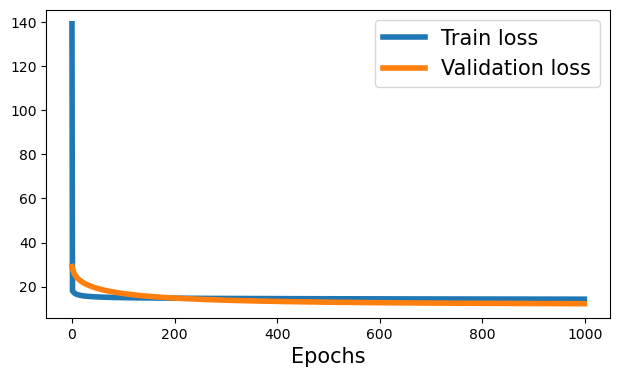

In [157]:
history = history_fit.history
fig = plt.figure(figsize=(16, 4))
ax = fig.add_subplot(1, 2, 1)
plt.plot(history["loss"], lw=4)
plt.plot(history["val_loss"], lw=4)
plt.legend(["Train loss", "Validation loss"], fontsize=15)
plt.xlabel("Epochs", size=15)
plt.show()

In [158]:
y_pred = main_model.predict(dict(x_test))

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


In [160]:
y_pred.flatten()

array([27.13253  , 26.65301  , 21.874588 , 25.731857 , 29.069233 ,
       10.122887 , 30.931469 , 38.047043 , 25.986217 , 22.07027  ,
       27.714573 , 15.948357 , 14.4268875, 15.942253 , 26.004108 ,
       22.445492 , 28.16513  , 21.777214 , 33.73335  , 35.398907 ,
       28.526875 , 32.6165   , 18.870522 , 24.690693 , 20.29359  ,
       27.874847 , 25.043373 , 19.76105  , 25.625372 , 28.905819 ,
       32.119915 , 31.424213 , 25.14838  , 20.870169 , 30.091175 ,
        6.2622905, 31.08119  , 34.095028 , 11.076027 , 11.866001 ,
       14.423645 , 16.186272 , 15.224192 , 28.666824 , 24.247818 ,
       17.948582 , 29.570621 , 26.464859 , 27.332851 , 28.016521 ,
       19.323563 , 28.561083 , 21.024754 , 21.811611 , 16.179924 ,
       13.9025135, 16.044365 , 25.26752  , 26.02172  , 10.955933 ,
       26.355484 , 22.94393  , 30.111992 , 32.73619  , 24.69532  ,
       19.814625 , 23.381145 , 23.580477 , 32.564438 , 27.03312  ,
       26.819006 , 26.003036 , 32.65031  , 22.152466 , 25.7491

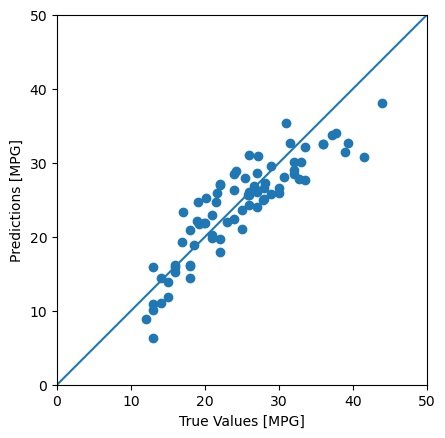

In [161]:
a = plt.axes(aspect='equal')
plt.scatter(y_test, y_pred.flatten())
plt.xlabel('True Values [MPG]')
plt.ylabel('Predictions [MPG]')
lims = [0, 50]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)

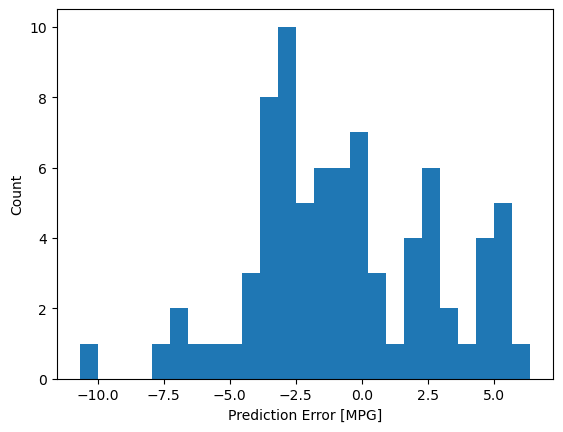

In [162]:
error = y_pred.flatten() - y_test
plt.hist(error, bins=25)
plt.xlabel('Prediction Error [MPG]')
_ = plt.ylabel('Count')
